# Testing and Evaluation on Test Dataset

In [1]:
import os
import re
import cv2
import time
import tensorflow as tf
import keras
import glob
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Activation
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, UpSampling2D
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pprint import pprint
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

import logging
logging.getLogger('tensorflow').disabled = True

### Load trained models

In [2]:
class UnitNormalize(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UnitNormalize, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=2, epsilon=1e-6)

In [3]:
gen_model_pth = './saved_models/generator.h5'
if os.path.exists(gen_model_pth):
    print('Load generator model')
    generator = load_model(gen_model_pth, custom_objects={'UnitNormalize': UnitNormalize})
    
dis_model_pth = './saved_models/discriminator.h5'
if os.path.exists(dis_model_pth):
    print('Load discriminator model')
    discriminator = tf.keras.models.load_model(dis_model_pth, compile=False)

Load generator model
Load discriminator model


### Load and Preprocess Test Dataset

In [4]:
img_dir = '../dataset/sfs-net/'

test_files = glob.glob(img_dir + 'test/0603/*normal*.png')

def preprocess(images):
    images = tf.image.resize(images, [256, 256])
    images = tf.cast(images, tf.float32)
    images = (images - 127.5) / 127.5 # [-1, 1]
    return images


def load_and_preprocess_image(file_path):
    # Load the image from file
    image = tf.io.read_file(file_path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Preprocess the image
    image = preprocess(image)
    return image

def normalise(images):
    images,images_norm = tf.linalg.normalize(images, axis=2) #Normalise the input data
    return images

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

test_dataset = test_dataset.map(load_and_preprocess_image)

test_dataset = test_dataset.map(normalise)

batch_size = 15
test_dataset = test_dataset.batch(batch_size).shuffle(105).prefetch(tf.data.experimental.AUTOTUNE)

print("Test dataset size: {}".format(len(test_files)))
print("Image Shape: {}".format(test_dataset.element_spec))

Test dataset size: 105
Image Shape: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)


### Generate Irregular Mask (batch size) （generate fixed masking lines for testing）

In [5]:
def mask_irregular(batch_size, mask_width, mask_height):
    
     
   # Define the fixed coordinates, thickness, and number of lines
    fixed_lines = [
        {'x1': 10, 'y1': 10, 'x2': 100, 'y2': 100, 'thickness': 3},
        {'x1': 50, 'y1': 150, 'x2': 150, 'y2': 50, 'thickness': 4},
        {'x1': 200, 'y1': 50, 'x2': 250, 'y2': 250, 'thickness': 5},
        {'x1': 10, 'y1': 200, 'x2': 100, 'y2': 300, 'thickness': 2},
        {'x1': 150, 'y1': 10, 'x2': 200, 'y2': 100, 'thickness': 6},
        {'x1': 300, 'y1': 150, 'x2': 350, 'y2': 50, 'thickness': 3},
        {'x1': 180, 'y1': 50, 'x2': 180, 'y2': 300, 'thickness': 3},
        {'x1': 50, 'y1': 50, 'x2': 350, 'y2': 350, 'thickness': 8},
        {'x1': 100, 'y1': 100, 'x2': 300, 'y2': 300, 'thickness': 6},
        {'x1': 50, 'y1': 30, 'x2': 150, 'y2': 100, 'thickness': 10},
        {'x1': 80, 'y1': 60, 'x2': 70, 'y2': 400, 'thickness': 4},
        {'x1': 120, 'y1': 65, 'x2': 135, 'y2': 270, 'thickness': 9},
        {'x1': 350, 'y1': 250, 'x2': 200, 'y2': 80, 'thickness': 7},
        {'x1': 160, 'y1': 300, 'x2': 280, 'y2': 60, 'thickness': 3},
        {'x1': 180, 'y1': 200, 'x2': 60, 'y2': 170, 'thickness': 4},
        {'x1': 100, 'y1': 100, 'x2': 100, 'y2': 100, 'thickness': 8},
        {'x1': 300, 'y1': 300, 'x2': 300, 'y2': 300, 'thickness': 8},
        {'x1': 200, 'y1': 200, 'x2': 200, 'y2': 200, 'thickness': 7},
        {'x1': 100, 'y1': 100, 'x2': 100, 'y2': 100, 'thickness': 6},
        {'x1': 50, 'y1': 50, 'x2': 50, 'y2': 50, 'thickness': 6},
        {'x1': 25, 'y1': 150, 'x2': 300, 'y2': 70, 'thickness': 3},
        {'x1': 65, 'y1': 67, 'x2': 30, 'y2': 30, 'thickness': 3},
        {'x1': 80, 'y1': 80, 'x2': 80, 'y2': 80, 'thickness': 8},
        {'x1': 160, 'y1': 160, 'x2': 160, 'y2': 160, 'thickness': 9},
        {'x1': 320, 'y1': 320, 'x2': 320, 'y2': 320, 'thickness': 2},
        {'x1': 55, 'y1': 270, 'x2': 30, 'y2': 200, 'thickness': 12},
        {'x1': 118, 'y1': 118, 'x2': 118, 'y2': 118, 'thickness': 5},
        {'x1': 20, 'y1': 100, 'x2': 200, 'y2': 150, 'thickness': 2},
        {'x1': 20, 'y1': 10, 'x2': 100, 'y2': 100, 'thickness': 6},
        {'x1': 80, 'y1': 300, 'x2': 150, 'y2': 60, 'thickness': 7},
        {'x1': 200, 'y1': 50, 'x2': 250, 'y2': 250, 'thickness': 4},
        {'x1': 30, 'y1': 200, 'x2': 200, 'y2': 300, 'thickness': 3},
        {'x1': 40, 'y1': 50, 'x2': 340, 'y2': 222, 'thickness': 8},
        
    ]
    
    mask = np.zeros((batch_size, mask_width, mask_height, 1))

    for line in fixed_lines:
        x1, y1, x2, y2, thickness = line['x1'], line['y1'], line['x2'], line['y2'], line['thickness']
        
        for i in range(batch_size):
            cv2.line(mask[i], (x1, y1), (x2, y2), (1, 1, 1), thickness)

    return np.float32(((1 - mask) * 2) - 1) # [-1, 1]

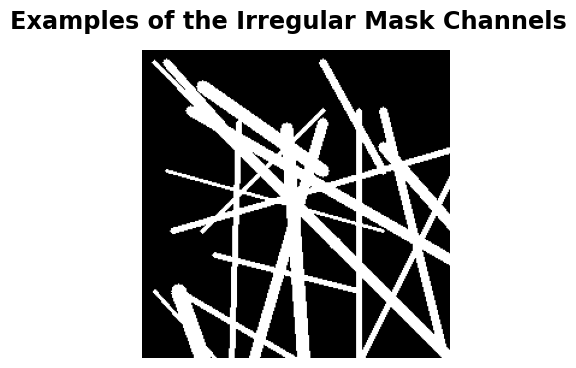

In [6]:
irregular_mask_examples = mask_irregular(6, 256, 256)
for ax, img in zip(ImageGrid(plt.figure(figsize=(6, 4)), 111, nrows_ncols=(1, 1), axes_pad=0.3), 
                   irregular_mask_examples):
    ax.imshow((img+1)/2, cmap='binary')
    ax.axis('off')
plt.suptitle('Examples of the Irregular Mask Channels', fontsize='xx-large',fontweight='heavy')
plt.show()

### Generate the masked imgs (batch size)

In [7]:
def masked_imgs(raw_imgs, mask_channels):
    
    raw_imgs = (raw_imgs + 1.0) / 2.0 # [0, 1]
    mask_channels = (mask_channels + 1.0) / 2.0 # [0, 1]
    
    masked_images = np.multiply(raw_imgs, mask_channels)
    
    masked_images = (masked_images * 2.0) - 1.0 # [-1, 1]
    
#     masked_images[:][masked_images[:] == 0] = 1. # Set the white mask
    
    return masked_images

### Generate the pred only masked region imgs (batch size)

In [8]:
def only_masked_region_pred_imgs(mask_channels, masked_imgs, pred_imgs):
    
    mask_channels = (mask_channels + 1.0) / 2.0 # [0, 1]
    masked_imgs = (masked_imgs + 1.0) / 2.0 # [0, 1]
    pred_imgs = (pred_imgs + 1.0) / 2.0 # [0, 1]
    
    masked_region_pred_imgs = masked_imgs + pred_imgs * (1.0 - mask_channels)
    
    masked_region_pred_imgs = (masked_region_pred_imgs * 2.0) - 1.0 # [-1, 1]
    
    return masked_region_pred_imgs

### Painting Function

In [9]:
def generator_plot_images(gen_model, text, dataset, num=3):
    
    for images_batch in dataset.take(1):
        raw_images = images_batch
        mask_channels = mask_irregular(raw_images.shape[0], raw_images.shape[1], raw_images.shape[2])
        masked_images = masked_imgs(raw_images, mask_channels)
        pred_images = gen_model([masked_images, mask_channels], training=False)
#         print("pred_images.shape",pred_images.shape)
        pred_images, pred_norm = tf.linalg.normalize(pred_images, axis=3)
#         print("pred_images.shape",pred_images.shape)
#         print("pred_norm.shape",pred_norm.shape)
        
        masked_region_pred_images = only_masked_region_pred_imgs(mask_channels, masked_images, pred_images)
    
    grid = ImageGrid(plt.figure(figsize=(16, num*4)), 111, nrows_ncols=(num, 4), axes_pad=0.28)
    
    for i in range(num):
        
        ax = grid[i*4]
        ax.imshow((raw_images[i]+1)/2)
        ax.set_title('Raw {} Img'.format(text))
        ax.axis('off')

        ax = grid[i*4+1]
        ax.imshow((masked_images[i]+1)/2)
        ax.set_title('Masked {} Img'.format(text))
        ax.axis('off')

        ax = grid[i*4+2]
        ax.imshow((pred_images[i]+1)/2)
        ax.set_title('Pred {} Img'.format(text))
        ax.axis('off')
        
        ax = grid[i*4+3]
        ax.imshow((masked_region_pred_images[i]+1)/2)
        ax.set_title('Pred Only Masked Reg. {} Img'.format(text))
        ax.axis('off')
        
    plt.show()

In [10]:
def plot_loss_accuracy(loss_list, accuracy_list, title, start=0, Acc='Accuracy'):
    x_values = range(start, start + len(loss_list))
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x_values, loss_list, color='tab:red')
    ax2.plot(x_values, accuracy_list, color='tab:blue')

    ax1.set_xlabel('Epochs', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', color='tab:red', fontsize=13, fontweight='bold')
    ax2.set_ylabel(Acc, color='tab:blue', fontsize=13, fontweight='bold')

    ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=13)
    ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=13)

    plt.title(title, fontsize=13, fontweight='bold')
    plt.show()

### Define the loss

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
# Cosine Similarity
cosine_loss = tf.keras.losses.CosineSimilarity(axis=3)

### Generator (encoder-decoder network)

In [12]:
# generator loss
def generator_loss(fake_output, target_images, generated_images, 
                   lambda_reconstruction = 999.0, lambda_adversarial=1.0):
    
    reconstruction_loss = cosine_loss(target_images, generated_images)
    
    adversarial_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    total_loss = lambda_reconstruction * reconstruction_loss + lambda_adversarial * adversarial_loss
    
    return total_loss

In [13]:
def generator_ssim(target_images, generated_images):
#     print("generator_ssim", tf.shape(target_images), tf.shape(generated_images))
    ssim = tf.image.ssim(target_images, generated_images, max_val=2.0)
    ssim = tf.reduce_mean(ssim)
    return ssim

In [14]:
def generator_psnr(target_images, generated_images):
    psnr = tf.image.psnr(target_images, generated_images, max_val=2.0)
    psnr = tf.reduce_mean(psnr)
    return psnr

### Discriminator

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def discirminator_acc(real_output, fake_output):
    real_acc = tf.reduce_mean(tf.cast(tf.greater(real_output, 0.5), tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(tf.less(fake_output, 0.5), tf.float32))
    total_acc = (real_acc + fake_acc) / 2.0
    return total_acc

### Assessment Function

In [17]:
def assessment(dataset):
    
    epoch_gen_loss_list = []
    epoch_gen_ssim_list = []
    epoch_gen_psnr_list = []
    epoch_dis_loss_list = []
    epoch_dis_acc_list = []
    
    for images_batch in dataset:
        raw_images = images_batch
        mask_channels = mask_irregular(raw_images.shape[0], raw_images.shape[1], raw_images.shape[2])
        masked_images = masked_imgs(raw_images, mask_channels)
    
        generated_images = generator([masked_images, mask_channels], training=False)
    
        real_output = discriminator(raw_images, training=False)
        fake_output = discriminator(generated_images, training=False)
    
        disc_loss = discriminator_loss(real_output, fake_output)
        disc_acc = discirminator_acc(real_output, fake_output) 
        gen_loss = generator_loss(fake_output, raw_images, generated_images)
        gen_ssim = generator_ssim(raw_images, generated_images)
        gen_psnr = generator_psnr(raw_images, generated_images)

        epoch_gen_loss_list.append(gen_loss.numpy())
        epoch_gen_ssim_list.append(gen_ssim.numpy())
        epoch_gen_psnr_list.append(gen_psnr.numpy())
        epoch_dis_loss_list.append(disc_loss.numpy())
        epoch_dis_acc_list.append(disc_acc.numpy())

    gen_epoch_loss = sum(epoch_gen_loss_list) / len(epoch_gen_loss_list)
    gen_epoch_ssim = sum(epoch_gen_ssim_list) / len(epoch_gen_ssim_list)
    gen_epoch_psnr = sum(epoch_gen_psnr_list) / len(epoch_gen_psnr_list)   
    dis_epoch_loss = sum(epoch_dis_loss_list) / len(epoch_dis_loss_list)
    dis_epoch_acc = sum(epoch_dis_acc_list) / len(epoch_dis_acc_list)

    return gen_epoch_loss, gen_epoch_ssim, gen_epoch_psnr, dis_epoch_loss, dis_epoch_acc

### Testing on generator (Test dataset) (untrained data)

In [18]:
test_gen_loss_avg, test_gen_ssim_avg, test_gen_psnr_avg, test_dis_loss_avg, test_dis_acc_avg = assessment(test_dataset)
print("Test dataset Avg LOSS: {:.2f}\nTest dataset Avg SSIM: {:.2f}%\nTest dataset Avg PSNR: {:.2f}\nTest dataset Disc Avg Loss : {:.2f}\nTest dataset Disc Avg ACC : {:.2f}%".format(test_gen_loss_avg, test_gen_ssim_avg*100, test_gen_psnr_avg, test_dis_loss_avg, test_dis_acc_avg*100))

Test dataset Avg LOSS: -939.65
Test dataset Avg SSIM: 12.34%
Test dataset Avg PSNR: 11.47
Test dataset Disc Avg Loss : 1.68
Test dataset Disc Avg ACC : 50.00%


In [19]:
print('Pred time for a batch')
for images_batch in test_dataset.take(1):
    test_raw_images = images_batch
    test_mask_channels = mask_irregular(test_raw_images.shape[0], test_raw_images.shape[1], test_raw_images.shape[2])
    test_masked_images = masked_imgs(test_raw_images, test_mask_channels)
    test_pred_images = generator.predict([test_masked_images, test_mask_channels], batch_size=batch_size)

Pred time for a batch
1/1 [==============================] - 0s 246ms/step


One batch from test dataset
Test dataset Batch LOSS: -945.57
Test dataset Batch SSIM: 12.19%
Test dataset Batch PSNR: 11.46


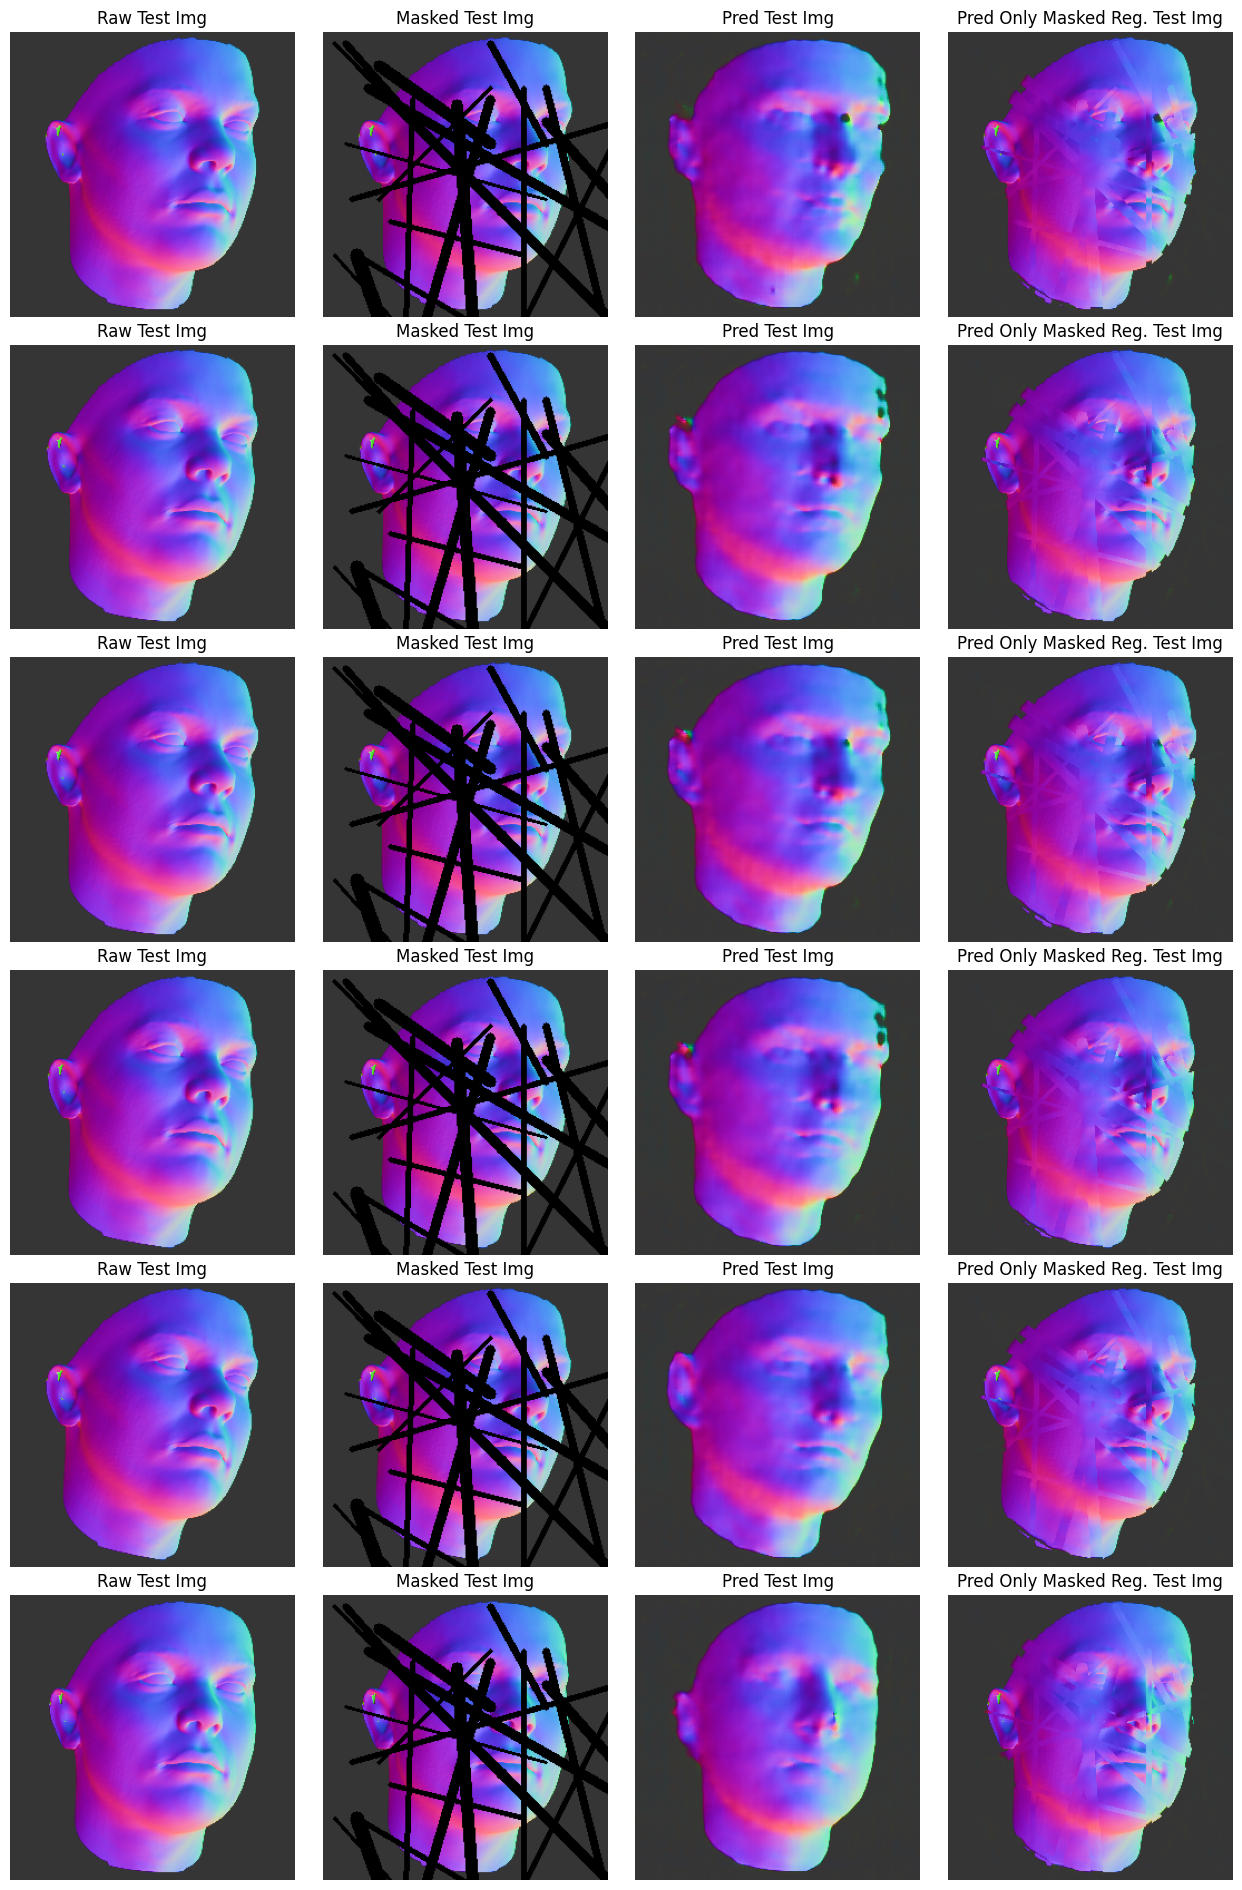

In [20]:
test_fake_output_batch = discriminator(test_pred_images, training=False)
test_gen_loss_batch = generator_loss(test_fake_output_batch, test_raw_images, test_pred_images)
test_gen_ssim_batch = generator_ssim(test_raw_images, test_pred_images)
test_gen_psnr_batch = generator_psnr(test_raw_images, test_pred_images)
print("One batch from test dataset\nTest dataset Batch LOSS: {:.2f}\nTest dataset Batch SSIM: {:.2f}%\nTest dataset Batch PSNR: {:.2f}".format(test_gen_loss_batch, test_gen_ssim_batch*100, test_gen_psnr_batch))
generator_plot_images(generator, 'Test', test_dataset, num = 6)

### Reading and plotting data from log data file

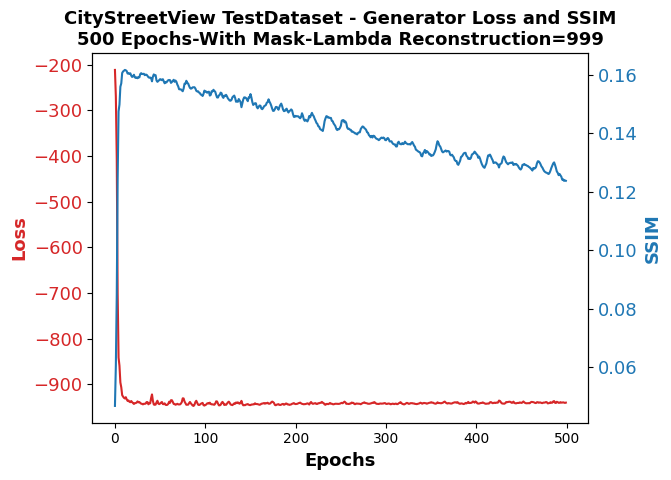

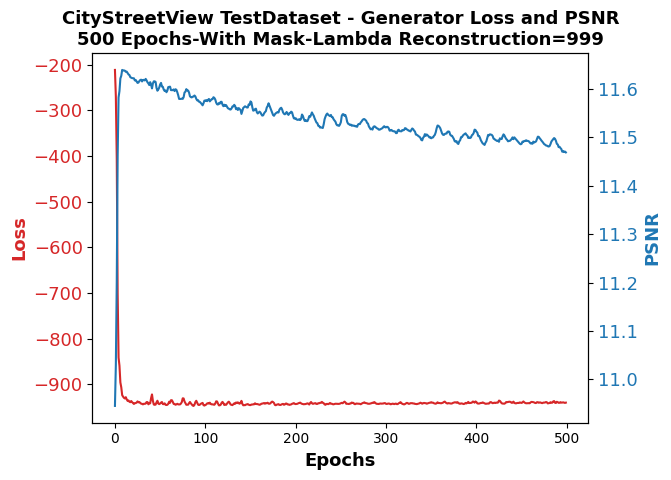

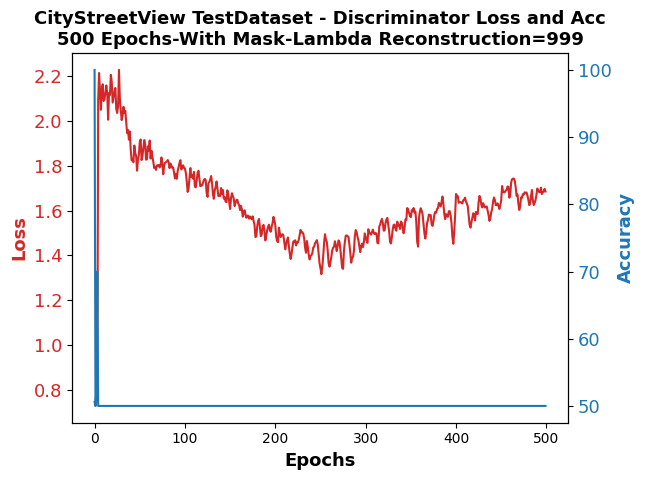

In [22]:
# Read the log file
with open('./saved_logs/GAN_training_results.txt', 'r') as log_file:
    log_data = log_file.read()

# Use regular expressions to extract values
pattern = r"Test_Gen_loss: (-?\d+\.\d+) Test_Gen_SSIM: (\d+\.\d+) Test_Gen_PSNR: (\d+\.\d+) Test_Dis_loss: (\d+\.\d+) Test_Dis_acc: (\d+\.\d+)%"

test_metrics = re.findall(pattern, log_data)

test_gen_loss = [float(metric[0]) for metric in test_metrics]
test_gen_ssim = [float(metric[1]) for metric in test_metrics]
test_gen_psnr = [float(metric[2]) for metric in test_metrics]
test_dis_loss = [float(metric[3]) for metric in test_metrics]
test_dis_acc = [float(metric[4]) for metric in test_metrics]


# Call the plot_loss_accuracy function for each pair of values
plot_loss_accuracy(test_gen_loss, test_gen_ssim, 'CityStreetView TestDataset - Generator Loss and SSIM\n500 Epochs-With Mask-Lambda Reconstruction=999', Acc='SSIM')
plot_loss_accuracy(test_gen_loss, test_gen_psnr, 'CityStreetView TestDataset - Generator Loss and PSNR\n500 Epochs-With Mask-Lambda Reconstruction=999', Acc='PSNR')
plot_loss_accuracy(test_dis_loss, test_dis_acc, 'CityStreetView TestDataset - Discriminator Loss and Acc\n500 Epochs-With Mask-Lambda Reconstruction=999')